In [208]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import feedparser
from collections import Counter
import nltk
import re
import pdb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from textblob import TextBlob

from sklearn.metrics.pairwise import pairwise_distances
import itertools
import random

In [2]:
#method accepts a BeautifulSoup parsed HTML object and returns a list of <a> tags of job posts
def get_job_posts(soup_object):
    
    job_posts = []
    a_s = soup_object.find_all('a')
    
    for a in a_s:
        try:
            if u'jobtitle' in a['class']:
                job_posts.append(a)
        except:
            next
    
    return job_posts

In [3]:
def replace_spaces(text):
    
    replace_list = ['machine learning', 'neural network', 'decision tree', 'graph database'
               'supervised learning', 'unsupervised learning', 'reinforcement learning', 
               'logistic regression', 'linear regression', 'naive bayes', 'random forest', 
               'deep learning', 'support_vector_machines', 'advanced degree', 'computer science'
               'ph d', 'm sc', 'b sc', 'b a' 'feature selection', 'natural language', 'sql server'
                'operations research', 'voted best place to work', 'cloud computing', 'century link']
    
    for word in replace_list:
        text = text.replace(word, word.replace(' ', '_'))
        
    return text

In [45]:
#method accepts a link to a job post and returns a list of 
def get_words(job_post_href):
    
    try:
        response = requests.request('GET', job_post_href)
        html = response.content
        post_soup = BeautifulSoup(html, "html.parser")
    except:
        print 'didnt work with url %s'%job_post_href, '\n'*3 
        return []
    

    
    text = post_soup.get_text().lower()
    
    # keep only letters, but keep '+' for 'c++', '#' for 'c#','3' for 'd3,
    # '2' for 'db2', and  '-' for 'scikit-learn'
    text = re.sub("[^a-z+#32-]"," ", text)
        
    #replace spaces in between important phrases with underscores so they don't get seperated as different words
    text = replace_spaces(text)
    
    
    
    #break into lines to get rid of the annoying '\n' characters. Also project to lowercase.
    lines = [line.strip().lower() for line in text.splitlines()]

    words = []
    for line in lines:
        words += [each_word for each_word in line.split()]
        
    #Lighten the load by getting rid of basic stopwords, like "the", "or" etc    
    words = set(words) - set(nltk.corpus.stopwords.words("english")) 
    
    return text, words
    

In [44]:
#method accepts a list of words in a job post, and creates sets according to pre-determined sets
def words_by_category(job_posts):
        
    languages = set(['r', 'python', 'java', 'scala', 'c', 'c++', 'c#', 'c--', 
                            'f#', 'groovy', 'julia', 'jscript', 
                            'matlab', 'perl', 'javascript', 'php', 'swift', 'coffeescript'
                            'coffee', 'sql','psql', 'tsql',  'mathematica', 'wolfram', 'pascal'])#want to include 'go!' once find out how to allow '!'
    
    frameworks = set(['angular',  'angularjs', 'typescript' ,'backbone', 'underscore' ,
                      'asp', 'node', 'django', 'flask' ])
    
    hadoop_technologies = set(['hadoop', 'pig', 'mapreduce', 'spark', 'hive', 'flume', 
                              'shark', 'zookeeper', 'mahout' ])

    #operating systems and tools
    operating_system_tools = set(['unix', 'osx', 'bash', 'batch' , 'curl', 'linux', 'windows', 'git' ])
    
    cloud_computing = set(['cloud_computing', 'aws', 'azure', 'cloudera', 'chef', 'joyent', 'rackspace', 
                           'century_link' ])
        
    machine_learning_algorithms = set(['decision_trees', 'clustering', 'regression', 'anova', 
                                       'k-means', 'neural_networks', 'supervised learning', 'unsupervised_learning',
                                       'reinforcement_learning', 'logistic_regression', 'linear_regression', 'naive_bayes', 'random_forest', 
                                       'deep_learning', 'pca', 'shrinkage', 'regression', 'support_vector_machines', 'svm', 
                                      'boosted', 'feature_selection', 'natural_language', 'nlp', 'cart', ])
    
    analysis_tools = set(['excel', 'spss', 'sas', 'tableau', 'visual_basic', 'd3' ])
    
    relational_databases = set(['redshift', 'postgressql', 'mysql', 'oracle', 'db2', 'h2', 
                               'sqlbase', 'libreoffice', 'netezza', 'azure', 'firebird', 'sql_server'])
    
    nosql_technologies = set(['nosql', 'hbase', 'cloudera', 'cassandra', 'scylla', 'mongodb', 'sonarw', 'jsonar', 
                             'elassandra', 'couchdb', 'rethinkdb', 'dynamodb', 'arangodb'])
    
    graph_databases = set(['graph_databases', 'graph_database', 'graph_databases', 'neo4j', 'arangodb', 'orientdb', 'graphbase', 'trinity'])
    
    academic_degrees = set(['bachelor', 'master','doctor', 'doctorate','mscphd' 'ph_d', 'phd', 
                            'm_sc', 'b_a', 'b_sc', 'advanced_degree', 'mba'])
    
    academic_disciplines = set(['mathematics', 'statistics','statistical', 'computer_science', 'business', 'stem', 
                               'operations_research', 'economics'])
    
    
    #for each job post see which skills appear. Leave as python.set data strucuture for effecient set operations later
    for post in job_posts:
        post['languages'] = set(post['words']) & languages
        post['frameworks'] = set(post['words']) & frameworks
        post['hadoop_technologies'] = set(post['words']) & hadoop_technologies
        post['operating_system_tools'] = set(post['words']) & operating_system_tools
        post['machine_learning_algorithms'] = set(post['words']) & machine_learning_algorithms
        post['analysis_tools'] = set(post['words']) & analysis_tools
        post['relational_databases'] = set(post['words']) & relational_databases
        post['nosql_technologies'] = set(post['words']) & nosql_technologies
        post['graph_databases'] = set(post['words']) & graph_databases
        post['academic_degrees'] = set(post['words']) & academic_degrees
        post['academic_disciplines'] = set(post['words']) & academic_disciplines
        post['academic_degrees'] = set(post['words']) & academic_degrees
        
        post['all_skills'] = languages.union(frameworks).union(
            hadoop_technologies).union(operating_system_tools).union(machine_learning_algorithms).union(
            analysis_tools).union(relational_databases).union(nosql_technologies).union(graph_databases).union(
            academic_degrees).union(academic_disciplines) & set(post['words'])
        
        

In [6]:
def crawl_indeed(query, city = "", experience_level = "", num_pages = 10):
    
    #clean parameters so that they match Indeed's protocol
    
    #spaces parameters seperated by '+'
    query = query.replace(' ', '+')
    city = city.replace(' ' , '+')
    
    #make sure experience_level is one of the four valid options
    if experience_level not in ['', 'entry_level', 'mid_level', 'senior_level']:
        experience_level = ''
        print "Experience level parameter not valid. Showing all experience levels"
    
    #build data in JSON-like format, given the heirarchial nature of the data
    data = list()
    
    #Indeed shows job posts 10 at a time, so each page starts with post 0, 10, 20...
    #Loop through the posts using the num_pages parameter
    
    page_start_numbers = np.arange(num_pages)*10
    
    for start_number in page_start_numbers:
        
        
        url = "http://www.indeed.com/jobs?q={0}&l={1}&explvl={2}&start={3}".format(
                query, city, experience_level, start_number)
            
        try:
            html = urlopen(url).read()
            page_soup = BeautifulSoup(html, "html.parser")
        except:
            next
    
        #get a list of all the <a class='jobtitle'></a> elemdents, which are job posts
        job_posts = get_job_posts(page_soup)

        for post in job_posts:
            
            #each job post gets a sub-dictionary
            post_data = dict()
            
            #attributes which are constant amongst all results for each execution
            post_data['query'] = query
            post_data['city'] = city
            
            #job title of that sepcific post
            post_data['title'] = post['title']
            
            
            #for each job post, extract the link to the post itself. Store in data dictionary for later
            post_href = 'http://www.indeed.com'+post['href']
            post_data['href'] = post_href
            
            #extract all the (cleaned up) words fromt that link
            full_text, post_words = get_words(post_href)
                        
            post_data['words'] =post_words
            data.append(post_data)
            
    words_by_category(data)
    return pd.DataFrame(data)

In [8]:
data_scientist_all = crawl_indeed('data scientist', num_pages = 40)
data_analyst_all = crawl_indeed('data analyst', num_pages = 40)
data_engineer_all = crawl_indeed('data engineer', num_pages = 40)
machine_learning_engineer_all = crawl_indeed('machine learning engineer', num_pages = 40 )

didnt work with url http://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AzE-GWYPxFZGI_92kcJvjHcwHh-UmCJSBCnWA3WKOu8yJ91v6VRoc40o0YF8jyebZHV8cNWxd7xzShgQBcHL8VMx0mXz8P68tT2fWxug52QAGysWqi_lLn19umDRnkApetf-7BNLBzMi_FLyO7c6EHJifTBOBMlDHTf2UReu0XrDP-fvf-bTl_ECqxA_GkO1P9K1ybT4Mr1gMi4MwL1RI-3VIQ-CP64ufz9uixMgEj8MuoGfCH3B1J_JEaWttGsJgkZscPGqOaDBzmOnL0f-8ubhQauLZhSxLk-y4QIe-CTSsB7BFPSxmzbX-Wisb8aexA3Y1ABVLFKQyalO94mjgU4FjFGvIDiQFAvSupOCRCIP5exuQ1ynXDhz9O3g1ALD5iJGvpJccKz1LUghd7AnsymkDuQfojmtaIprqtgFTwNFigBD8KO72cNYe0CLhaw2FqRAoT6ch8Zs28A78ScPAIR1hLtXza47EzKRRhevJpqQ==&p=2&sk=&fvj=0 



didnt work with url http://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AzE-GWYPxFZGI_92kcJvjHcwHh-UmCJSBCnWA3WKOu8yJ91v6VRoc40o0YF8jyebZHV8cNWxd7xzShgQBcHL8VMx0mXz8P68tT2fWxug52QAGysWqi_lLn19umDRnkApetf-7BNLBzMo3a9p6Lv8Jpv_DRwAs0lVA_IRB4naWhBpK-rReZ2s1MClZiDQ5f3Tb7WkR_AXRPf-IZw_Y7_obe9LamhtbiJ7K0i5MYSFT8kIv0XhE46xRRnvzN-CJh_Iq1qHERjr2PVgFqHlDzMXIOSeiDvJuxyroBZBJUbI3WNobN6YxH8t1ushCi4C8FjT79z_UEGk1_ezZ0AoW5DuwzG3k

In [43]:

data_scientist_nyc = crawl_indeed('data scientist', city = 'new york', num_pages = 30)
data_scientist_sanfran = crawl_indeed('data scientist', city = 'san fransisco', num_pages = 30)
data_scientist_boston = crawl_indeed('data scientist', city = 'boston', num_pages = 30)
data_scientist_chicago = crawl_indeed('data scientist', city = 'chicago', num_pages = 30)


didnt work with url http://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DUnwefsF7K5sI9KMOiuTab93Tl5aV87o5poBYEvjEbgE7oyuYH0UeAH0p2dm5KvWLlt1sZcevRoqCkONMldkncq2MYsgccBuDvJ-Cyd21C-zguN1sqx6Juikm5mXNubsvwSJQbC9m85r5URj9HT__6sgtbGMdLmVgIdDyl82bKqcguaxCxvNhSdhNwLZ3DRrM7c_2tV82e_l0Bou1k1O3zTb0_sVnbn6pgAUKDE51GBWlmyPZi20G2KiyVZrd--JPktv4Iniyffd_i5dW-yQkmrAVnFczcQI6a3TX6BVANfsaRhCd239l8BRiV6ZthRQqbZzjaD-1mkCG-Uo9ek5pJNBdHvnHoOY9bgKbEMwfkfdhMx2w2w5GuQcrOyXKmhCw1Cm1_7gQPeeqNJ0y3gDCIGQLEQuoecp4r9vtCJ1lOHmTCSpFxNk0Jr9Bk7Wmy9qrt9Mx3UYKNfHdB4cBT-NNuAoWjt3osB1B_B3iKRjdsZgUDtJHCZqu19zSivXQogK0OutmccjEiKOqKIaYtLwSZOMyOrHPtPx5siYJrfawnmMtGcg_O3-sXxjB0sUniLEkiguhKTf6fvfWVRRDWqfg1XfUOyOp4NDNegtZ06LC1Hs1F3jkfSmaijbuZQeK7qOr6KYqhz8tVtX6YeXQ3AjZV8HfvTcjzV1v8A2MTgvNg-vJTU9WtziEr645htayx3Yk7_v9BTYmjC7u1gORRiYKP_ckF_Py1Rq4_DIZKRUYDEB4T5ghQt3Y6bd_liOTd1dSL8F5ep3vUlNaPwWx5d6c2e8feQLilWwkdU5-bD18yn3krLctIU28b1cH_5NAasRpRsDBZodJf_Y-fl0b9Xmkb&p=4&sk=&fvj=0 



didnt work with url http://www.indeed.com/pagead/clk?mo=

In [ ]:
data_scientist_nyc = crawl_indeed('data scientist', city = 'new york', num_pages = 30)


In [12]:
data_scientist_all.head(10)

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words
0,{},{business},"{r, cart, business}",{},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,{r},{cart},{},{},data+scientist,{},"Director, Competitive Intelligence","{limited, applyemailsubjectapplication, 3cli, ..."
1,{},{},{},{},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,{},{},{},{},data+scientist,{},Data Scientist,[]
2,{},{statistics},"{statistics, java, scala, python, hadoop, juli...",{},,{},{},"{hadoop, pig}",http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{java, scala, python, julia, r, sql}",{},{},{},data+scientist,{},Data Scientist,"{operations, savebuttonoutsidecontentblock, he..."
3,{},{business},"{business, sql, python, decision_trees, javasc...",{},,{angular},{},{spark},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r, javascript, sql, perl}","{reinforcement_learning, decision_trees, regre...",{},{linux},data+scientist,{},Data Scientist,"{code, sales, setcustomvar, global, results, c..."
4,{master},"{mathematics, statistics, business}","{statistics, business, python, excel, cart, r,...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r}","{neural_networks, cart}",{},{},data+scientist,{},Data Scientist – Predictive Analytics,"{applyemailsubjectapplication, code, ftltab, m..."
5,{bachelor},{business},"{c, business, javascript, excel, bachelor, r, ...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, javascript, r, sql}",{},{},{},data+scientist,{},Data Specialist,"{ptk, sg-btn-block, skip, cwoa, focus, #2e, sn..."
6,{phd},{},"{r, angular, javascript, phd}",{},,{angular},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{r, javascript}",{},{},{},data+scientist,{},"Principal Scientist, Analytical Services","{chain, dissolution, results, existing, catch,..."
7,{advanced_degree},"{mathematics, statistics, business}","{clustering, statistics, business, nosql, adva...","{sas, tableau, spss}",,{angular},{},{hadoop},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{r, javascript, sql}","{clustering, regression}",{nosql},{},data+scientist,{h2},Marketing Data Scientist,"{educationbachelor, catch, ga, jv-job-list, au..."
8,{phd},"{mathematics, statistics}","{natural_language, c, statistics, tableau, jav...",{tableau},,{},{},{hadoop},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, javascript, r, sql}",{natural_language},{},{},data+scientist,{},Data Scientist,"{scorecardresearch, ptk, sg-btn-block, skip, c..."
9,"{bachelor, advanced_degree}","{mathematics, statistics, business}","{node, nlp, c, asp, java, advanced_degree, bus...",{},,"{node, asp}",{},"{spark, hive}",http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r, c, javascript, java}",{nlp},{},{},data+scientist,{h2},Data Scientist,"{code, skip, platforms, global, gz, themes, to..."


In [58]:
#each "skill" attribute is a python core set object
data_scientist_all.iloc[0]['all_skills']

{'business', 'cart', 'r'}

In [15]:
#accepts a processed dataframe, and a list of skill categories to include
def get_skill_frequency(df, *exclude_categories): 
    
    counter = Counter()
    for index, job_post in df.iterrows():
        for category_to_exclude in exclude_categories:
            skills = job_post['all_skills'] - job_post[category_to_exclude][0]
        for skill in skills: 
            counter[skill]+=1
    
    #convert values to a freqeuncy of total posts that have that skill
    number_of_posts = float(df.shape[0])
    
    for key in counter.keys():
        counter[key] = counter[key]/number_of_posts
    
    df = pd.DataFrame(data = counter, index = [0]).T
    
    df.sort_values(by = 0, inplace = True)

    return df
        
    

In [21]:
data_scientist_all_frequency = get_skill_frequency(data_scientist_all, ['academic_degrees'])
data_analyst_all_frequency = get_skill_frequency(data_analyst_all, ['academic_degrees'])
data_engineer_all_frequency = get_skill_frequency(data_engineer_all, ['academic_degrees'])
machine_learning_engineer_all_frequency = get_skill_frequency(machine_learning_engineer_all, ['academic_degrees'])

In [46]:
data_scientist_nyc_frequency = get_skill_frequency(data_scientist_nyc, ['academic_degrees'])
data_scientist_boston_frequency = get_skill_frequency(data_scientist_boston, ['academic_degrees'])
data_scientist_sanfran_frequency = get_skill_frequency(data_scientist_sanfran, ['academic_degrees'])
data_scientist_chicago_frequency = get_skill_frequency(data_scientist_chicago, ['academic_degrees'])

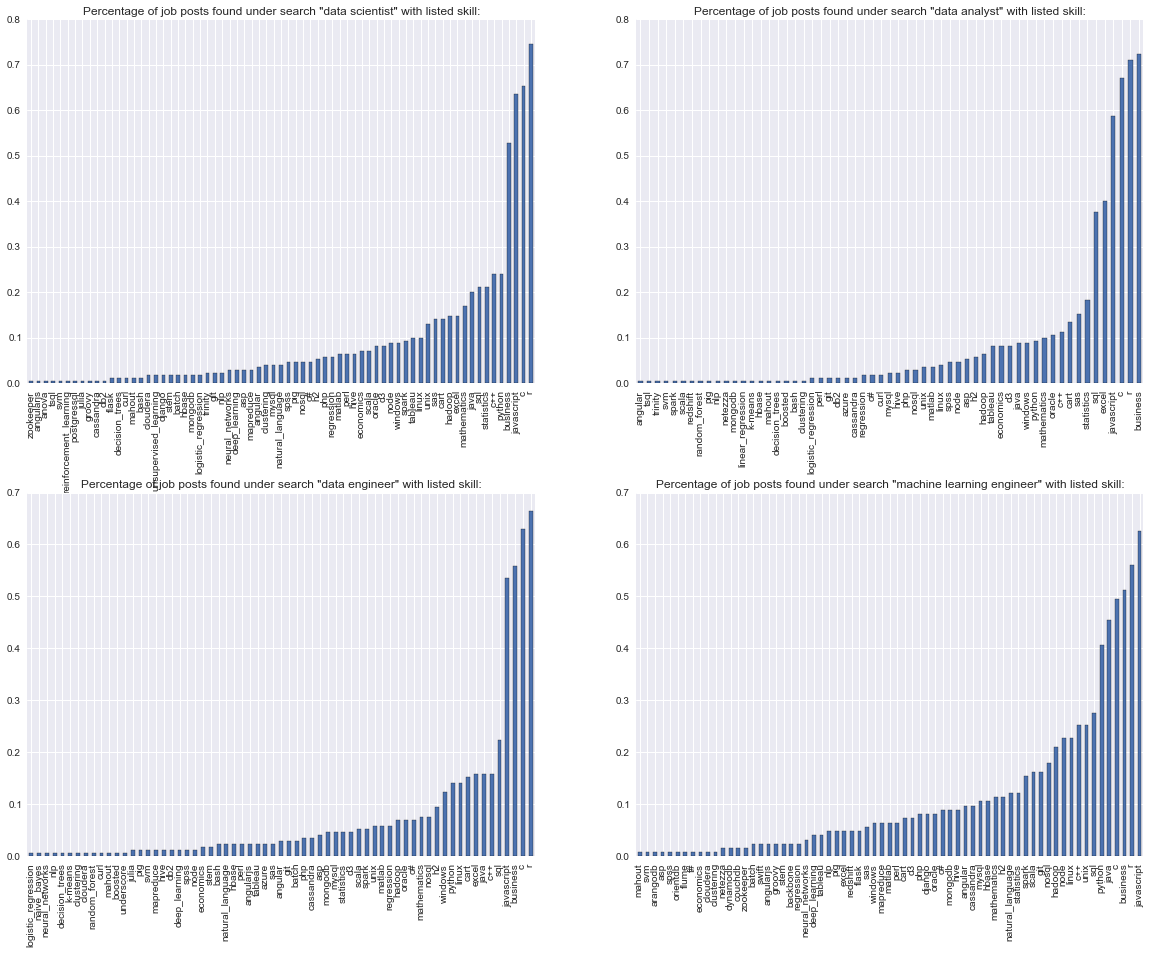

In [42]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.subplots_adjust(hspace = .3)
    
data_scientist_all_frequency.plot(ax=axes[0,0],  kind = 'bar', legend = None, 
                              title = 'Percentage of job posts found under search "data scientist" with listed skill:')

data_analyst_all_frequency.plot(ax=axes[0,1],  kind = 'bar', legend = None, 
                              title = 'Percentage of job posts found under search "data analyst" with listed skill:')

data_engineer_all_frequency.plot(ax=axes[1,0],  kind = 'bar', legend = None, 
                              title = 'Percentage of job posts found under search "data engineer" with listed skill:')

machine_learning_engineer_all_frequency.plot(ax=axes[1,1],  kind = 'bar', legend = None, 
                              title = 'Percentage of job posts found under search "machine learning engineer" with listed skill:')

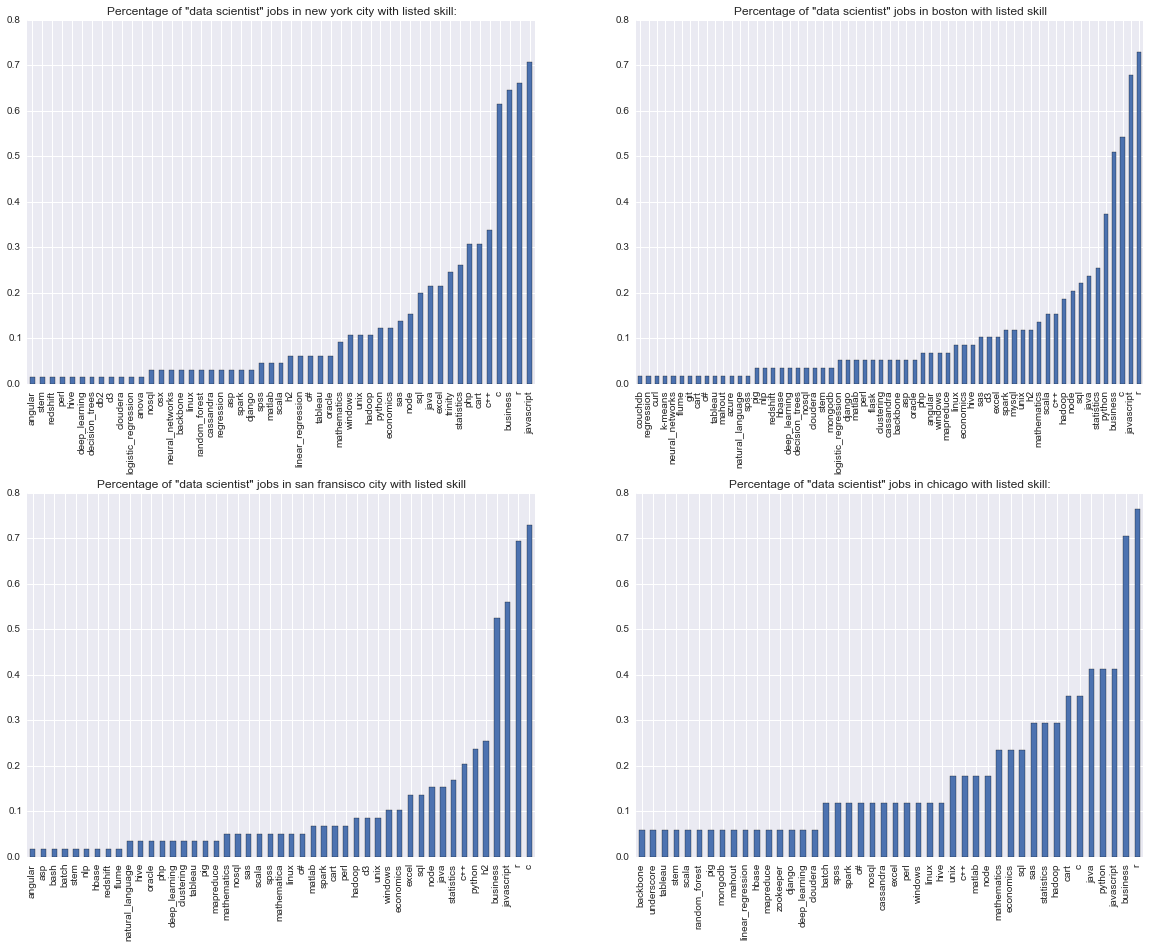

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.subplots_adjust(hspace = .3)
    
data_scientist_nyc_frequency.plot(ax=axes[0,0],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" jobs in new york city with listed skill:')

data_scientist_boston_frequency.plot(ax=axes[0,1],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" jobs in boston with listed skill')

data_scientist_sanfran_frequency.plot(ax=axes[1,0],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" jobs in san fransisco city with listed skill')

data_scientist_chicago_frequency.plot(ax=axes[1,1],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" jobs in chicago with listed skill:')

In [49]:
#takes a dataframe of job posts, and computes the cardinality of the skills set intersection as a simlarity score
def job_post_similarity_matrix(df, *categories_to_exclude):
    
    for category_to_exclude in categories_to_exclude:
        df['all_skills'] = df['all_skills'] - df['category_to_exclude']
        
    similarity_matrix = pd.pivot(df, index = 'title', columns = 'title', values = 'all_skills', agg_func = '-')

In [172]:
phd = set(['phd', 'doctorate', 'mscphd', 'mastersphd'])
data_scientist_phd = data_scientist_all[data_scientist_all.academic_degrees & phd]
machine_learning_engineer_phd = machine_learning_engineer_all[machine_learning_engineer_all.academic_degrees & phd]


masters = set(['masters', 'master','msc', 'mscphd', 'mastersphd'])
data_scientist_masters = data_scientist_all[data_scientist_all.academic_degrees & masters]
machine_learning_engineer_masters = machine_learning_engineer_all[machine_learning_engineer_all.academic_degrees & masters]


advanced_degree = set(['advanced_degree']).union(phd).union(masters)
data_scientist_advanced_degree = data_scientist_all[data_scientist_all.academic_degrees & advanced_degree]
machine_learning_engineer_advanced_degree = machine_learning_engineer_all[machine_learning_engineer_all.academic_degrees & advanced_degree]


bachelors = set(['bachelor', 'bachelors', 'bsc', 'ba'])
data_scientist_bachelors = data_scientist_all[data_scientist_all.academic_degrees & bachelors]
machine_learning_engineer_bachelors = machine_learning_engineer_all[machine_learning_engineer_all.academic_degrees & bachelors]


data_scientist_no_degree =  data_scientist_all[[len(degrees_set) == 0 
                                                for degrees_set in data_scientist_all.academic_degrees]]

machine_learning_engineer_no_degree =  machine_learning_engineer_all[[len(degrees_set) == 0 
                                                for degrees_set in machine_learning_engineer_all.academic_degrees]]


In [198]:
print 'number of data science positions:' , data_scientist_all.shape[0]
print 'number of machine learning engineer positions:' , machine_learning_engineer_all.shape[0]

number of data science positions: 170
number of machine learning engineer positions: 123


In [80]:
data_scientist_phd.head(2)

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words
6,{phd},{},"{r, angular, javascript, phd}",{},,{angular},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{r, javascript}",{},{},{},data+scientist,{},"Principal Scientist, Analytical Services","{chain, dissolution, results, existing, catch,..."
8,{phd},"{mathematics, statistics}","{natural_language, c, statistics, tableau, jav...",{tableau},,{},{},{hadoop},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, javascript, r, sql}",{natural_language},{},{},data+scientist,{},Data Scientist,"{scorecardresearch, ptk, sg-btn-block, skip, c..."


In [137]:
data_scientist_masters.head(2)

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words
4,{master},"{mathematics, statistics, business}","{statistics, business, python, excel, cart, r,...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r}","{neural_networks, cart}",{},{},data+scientist,{},Data Scientist – Predictive Analytics,"{applyemailsubjectapplication, code, ftltab, m..."
13,"{master, advanced_degree}",{business},"{c, java, advanced_degree, business, h2, excel...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, r, java}",{},{},{windows},data+scientist,{h2},"Manager, Data Analysis","{skip, dynamic, results, manager, manages, ga,..."


In [82]:
data_scientist_advanced_degree.head(2)

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words
4,{master},"{mathematics, statistics, business}","{statistics, business, python, excel, cart, r,...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r}","{neural_networks, cart}",{},{},data+scientist,{},Data Scientist – Predictive Analytics,"{applyemailsubjectapplication, code, ftltab, m..."
6,{phd},{},"{r, angular, javascript, phd}",{},,{angular},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{r, javascript}",{},{},{},data+scientist,{},"Principal Scientist, Analytical Services","{chain, dissolution, results, existing, catch,..."


In [83]:
data_scientist_bachelors.head(2)

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words
5,{bachelor},{business},"{c, business, javascript, excel, bachelor, r, ...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, javascript, r, sql}",{},{},{},data+scientist,{},Data Specialist,"{ptk, sg-btn-block, skip, cwoa, focus, #2e, sn..."
9,"{bachelor, advanced_degree}","{mathematics, statistics, business}","{node, nlp, c, asp, java, advanced_degree, bus...",{},,"{node, asp}",{},"{spark, hive}",http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r, c, javascript, java}",{nlp},{},{},data+scientist,{h2},Data Scientist,"{code, skip, platforms, global, gz, themes, to..."


In [89]:
data_scientist_no_degree.head(2)

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words
0,{},{business},"{r, cart, business}",{},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,{r},{cart},{},{},data+scientist,{},"Director, Competitive Intelligence","{limited, applyemailsubjectapplication, 3cli, ..."
1,{},{},{},{},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,{},{},{},{},data+scientist,{},Data Scientist,[]


In [181]:
perc_data_scientist_bachelors = data_scientist_bachelors.shape[0]/float(data_scientist_all.shape[0])
perc_data_scientist_masters = data_scientist_masters.shape[0]/float(data_scientist_all.shape[0])
perc_data_scientist_advanced_degree = data_scientist_advanced_degree.shape[0]/float(data_scientist_all.shape[0])
perc_data_scientist_phd = data_scientist_phd.shape[0]/float(data_scientist_all.shape[0])
perc_data_scientist_no_degree = data_scientist_no_degree.shape[0]/float(data_scientist_all.shape[0])

data_scientist_degree_percentages = pd.DataFrame(data = {'Percentage posts with masters': perc_data_scientist_bachelors,
                                     'Percentage posts with bachelors': perc_data_scientist_masters,
                                     'Percentage posts with advanced degree': perc_data_scientist_advanced_degree,
                                     'Percentage posts with phd': perc_data_scientist_phd,
                                     'Percentage posts with no degree specified': perc_data_scientist_no_degree}, 
                             index = [0]).T

In [186]:
perc_machine_learning_engineer_bachelors = machine_learning_engineer_bachelors.shape[0]/float(machine_learning_engineer_all.shape[0])
perc_machine_learning_engineer_masters = machine_learning_engineer_masters.shape[0]/float(machine_learning_engineer_all.shape[0])
perc_machine_learning_engineer_advanced_degree = machine_learning_engineer_advanced_degree.shape[0]/float(machine_learning_engineer_all.shape[0])
perc_machine_learning_engineer_phd = machine_learning_engineer_phd.shape[0]/float(machine_learning_engineer_all.shape[0])
perc_machine_learning_engineer_no_degree = machine_learning_engineer_no_degree.shape[0]/float(machine_learning_engineer_all.shape[0])

machine_learning_engineer_degree_percentages = pd.DataFrame(data = {'Percentage posts with masters': perc_machine_learning_engineer_bachelors,
                                     'Percentage posts with bachelors': perc_machine_learning_engineer_masters,
                                     'Percentage posts with advanced degree': perc_machine_learning_engineer_advanced_degree,
                                     'Percentage posts with phd': perc_machine_learning_engineer_phd,
                                     'Percentage posts with no degree specified': perc_machine_learning_engineer_no_degree}, 
                             index = [0]).T

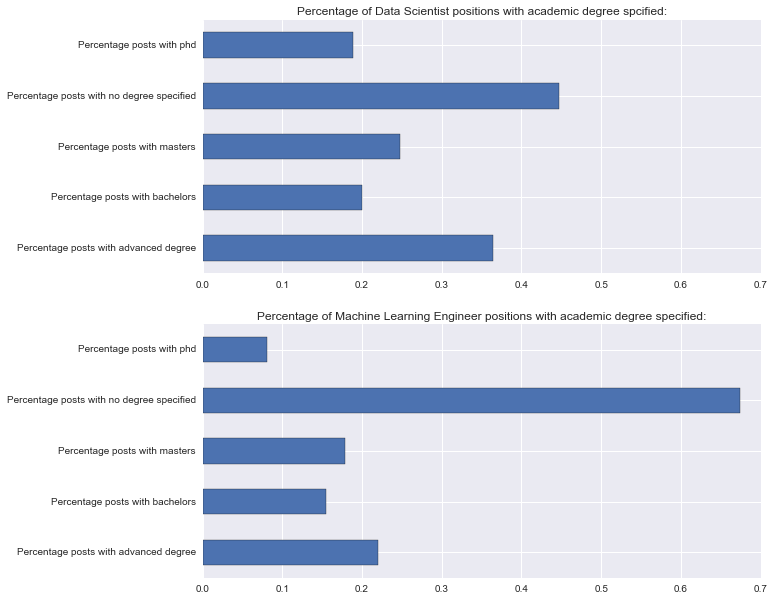

In [194]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))


data_scientist_degree_percentages.plot.barh(ax = axes[0], legend = None, figsize = (10, 10), xlim = (0, .7), 
                                        title = "Percentage of Data Scientist positions with academic degree spcified:")
machine_learning_engineer_degree_percentages.plot.barh(ax = axes[1], legend = None, figsize = (10, 10), xlim = (0, .7), 
                                        title = "Percentage of Machine Learning Engineer positions with academic degree specified:")

In [118]:
data_scientist_phd_frequency = get_skill_frequency(data_scientist_phd, ['academic_degrees'])
data_scientist_masters_frequency = get_skill_frequency(data_scientist_masters, ['academic_degrees'])
data_scientist_advanced_degree_frequency = get_skill_frequency(data_scientist_advanced_degree, ['academic_degrees'])
data_scientist_bachelors = get_skill_frequency(data_scientist_bachelors, ['academic_degrees'])
data_scientist_all_frequency = get_skill_frequency(data_scientist_all, ['academic_degrees'])

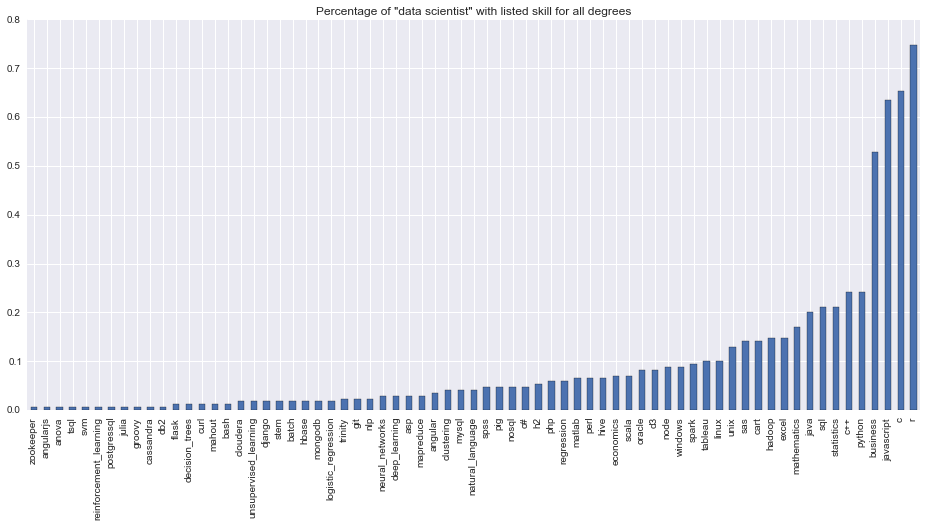

In [129]:
data_scientist_all_frequency.plot( kind = 'bar', legend = None, figsize = (16,7) ,
                              title = 'Percentage of "data scientist" with listed skill for all degrees')


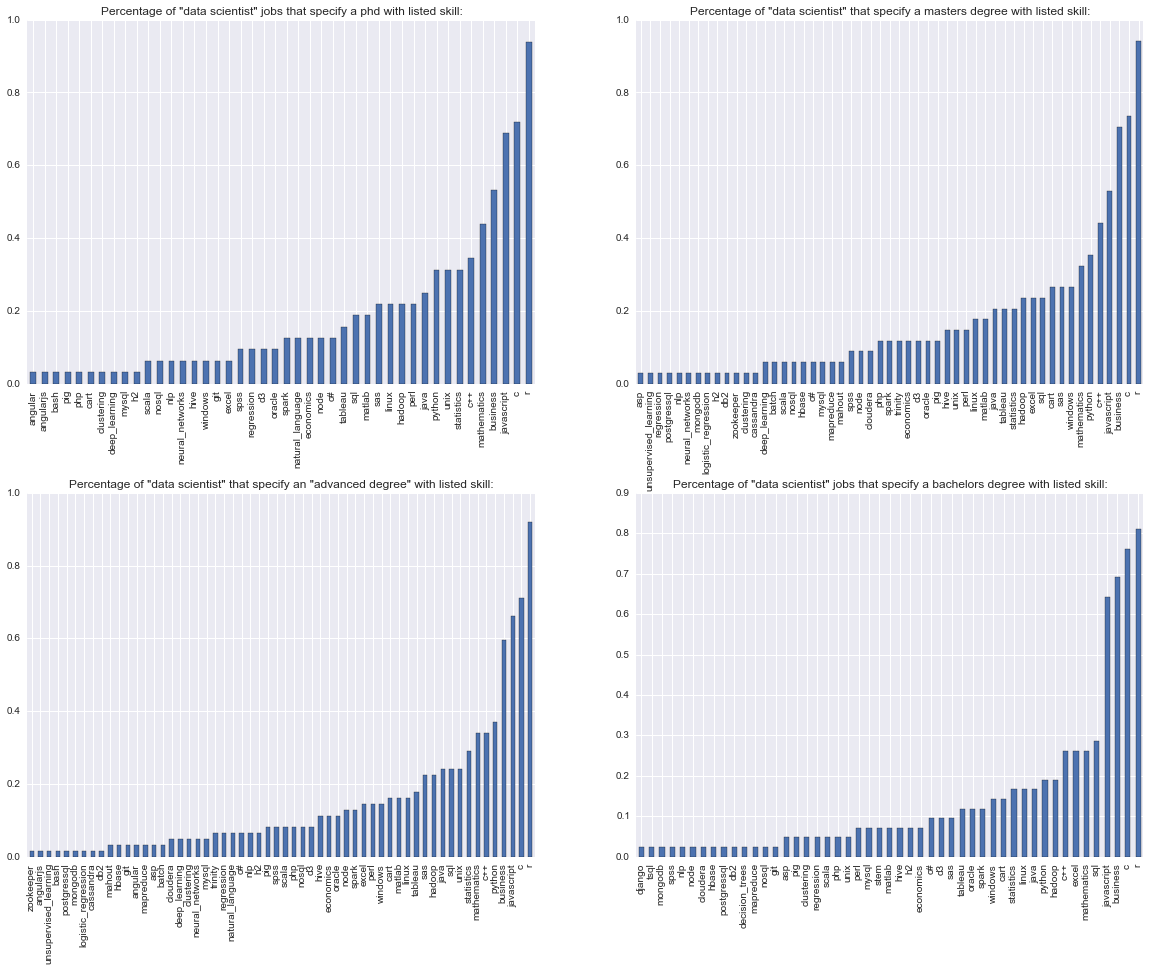

In [122]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.subplots_adjust(hspace = .3)


data_scientist_phd_frequency.plot(ax=axes[0,0],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" jobs that specify a phd with listed skill:')

data_scientist_masters_frequency.plot(ax=axes[0,1],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" that specify a masters degree with listed skill:')

data_scientist_advanced_degree_frequency.plot(ax=axes[1,0],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" that specify an "advanced degree" with listed skill:')

data_scientist_bachelors.plot(ax=axes[1,1],  kind = 'bar', legend = None, 
                              title = 'Percentage of "data scientist" jobs that specify a bachelors degree with listed skill:')


In [200]:
data_analyst_all['index'] = range(data_analyst_all.shape[0]) 

In [201]:
data_analyst_all.head()

,academic_degrees,academic_disciplines,all_skills,analysis_tools,city,frameworks,graph_databases,hadoop_technologies,href,languages,machine_learning_algorithms,nosql_technologies,operating_system_tools,query,relational_databases,title,words,index
0,{bachelor},"{mathematics, statistics, business}","{statistics, business, python, hadoop, hive, t...",{tableau},,{},{},"{hadoop, hive}",http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{python, r, sql}",{},{},{},data+analyst,{},Data Analyst,"{results, manages, ga, decisions, relationship...",0
1,{},{business},"{business, javascript, hadoop, cart, pig, orac...",{sas},,{},{},"{hadoop, pig}",http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{javascript, tsql, sql}",{cart},{},{},data+analyst,"{netezza, oracle}",Data Analyst / SQL Developer,"{code, skip, global, existing, founded, toggle...",1
2,{bachelor},"{mathematics, business}","{c, business, h2, excel, bachelor, r, mathemat...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, r}",{},{},{},data+analyst,{h2},Data Analyst,"{code, skip, focus, research, issues, aug, tu,...",2
3,{bachelor},{business},"{c, business, javascript, excel, bachelor, r, ...",{excel},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, javascript, r, sql}",{},{},{},data+analyst,{},DATA ANALYST,"{ptk, sg-btn-block, skip, cwoa, focus, existin...",3
4,{},{},"{c, r, javascript}",{},,{},{},{},http://www.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"{c, javascript, r}",{},{},{},data+analyst,{},Data Analyst,"{ptk, sg-btn-block, skip, cwoa, focus, snip, i...",4


In [202]:
skills = data_analyst_all.all_skills

In [206]:
def set_distance(skillset_0, skillset_1):
    return len(skillset_0 & skillset_1)

In [207]:
pairwise_distances(skills, skills, set_distance)

TypeError: float() argument must be a string or a number

In [203]:
skills

0      {statistics, business, python, hadoop, hive, t...
1      {business, javascript, hadoop, cart, pig, orac...
2      {c, business, h2, excel, bachelor, r, mathemat...
3      {c, business, javascript, excel, bachelor, r, ...
4                                     {c, r, javascript}
5                    {bachelor, r, excel, c, javascript}
6      {c, statistics, business, javascript, bachelor...
7                           {bachelor, c, business, sql}
8      {c, statistics, business, javascript, excel, b...
9                                                     {}
10     {nlp, statistics, business, nosql, python, jav...
11     {c, javascript, java, business, sql, bachelor,...
12                   {c, r, excel, regression, business}
13                               {bachelor, excel, cart}
14         {c, business, javascript, excel, bachelor, r}
15     {statistics, business, windows, excel, bachelo...
16       {statistics, business, excel, master, sql, sas}
17     {c, statistics, java, bu

In [210]:
import string
fnx = lambda: set(random.sample(string.ascii_uppercase, 7))
S = [fnx() for c in range(5)]

In [233]:
S

[{'C', 'D', 'E', 'K', 'N', 'P', 'X'},
 {'E', 'H', 'M', 'P', 'V', 'X', 'Y'},
 {'E', 'I', 'Q', 'S', 'T', 'X', 'Y'},
 {'C', 'I', 'M', 'R', 'S', 'V', 'Z'},
 {'A', 'E', 'H', 'K', 'R', 'U', 'W'}]

In [234]:
idx = range(len(S))

In [213]:
idx

[0, 1, 2, 3, 4]

In [378]:
pairs = itertools.combinations(idx, 2)

In [379]:
pairs

In [380]:
nt = lambda a, b: S[a].intersection(S[b])

In [381]:
res = dict([ [t, nt(*t)] for t in pairs ])

In [447]:
res

{(0, 1): {'E', 'P', 'X'},
 (0, 2): {'E', 'X'},
 (0, 3): {'C'},
 (0, 4): {'E', 'K'},
 (1, 2): {'E', 'X', 'Y'},
 (1, 3): {'M', 'V'},
 (1, 4): {'E', 'H'},
 (2, 3): {'I', 'S'},
 (2, 4): {'E'},
 (3, 4): {'R'}}

In [448]:
res[(2,3)]

{'I', 'S'}

In [449]:
def to_set(tup):
    return res[tup]

In [252]:
mesh = np.meshgrid(range(5), range(5))

In [440]:
X, Y = np.mgrid[0:5, 0:5]
positions = np.vstack([X.ravel(), Y.ravel()])
points = pd.Series(zip(positions[0], positions[1]))


In [446]:
df = pd.DataFrame(np.reshape(pd.DataFrame(points).as_matrix(), (5,-1)))

In [ ]:
a = zip(positions[0], positions[1])
data_type=np.dtype('int,int')
b = np.array([[tup] for tup in a], dtype = data_type)
b = np.reshape(b, (5,-1))


In [439]:
pd.DataFrame(a, split= False)

TypeError: __init__() got an unexpected keyword argument 'split'

In [355]:
points = pd.Series(zip(positions[0], positions[1]))

In [391]:
a = zip(positions[0], positions[1])

In [416]:
data_type=np.dtype('int,int')
b = np.asarray([[tup] for tup in a], dtype = data_type)

In [417]:
np.reshape(b, (5,-1))

array([[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
       [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
       [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
       [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
       [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]], 
      dtype=[('f0', '<i8'), ('f1', '<i8')])

In [361]:
pd.DataFrame(np.reshape(pd.DataFrame(points).as_matrix(), (5, -1)))

,0,1,2,3,4
0,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)"
1,"(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)"
2,"(2, 0)","(2, 1)","(2, 2)","(2, 3)","(2, 4)"
3,"(3, 0)","(3, 1)","(3, 2)","(3, 3)","(3, 4)"
4,"(4, 0)","(4, 1)","(4, 2)","(4, 3)","(4, 4)"


In [338]:
len(points)

25

In [341]:
df = pd.DataFrame.from_records(points)

In [309]:
np.array(tuples)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4]])

In [308]:
np.reshape(tuples, (5, -1))

array([[0, 0, 0, 1, 0, 2, 0, 3, 0, 4],
       [1, 0, 1, 1, 1, 2, 1, 3, 1, 4],
       [2, 0, 2, 1, 2, 2, 2, 3, 2, 4],
       [3, 0, 3, 1, 3, 2, 3, 3, 3, 4],
       [4, 0, 4, 1, 4, 2, 4, 3, 4, 4]])